In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5

In [17]:
"""# Deep Convolutional GAN"""

# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise
# Output : Mnist 이미지 크기인 28*28
inputs = keras.Input(shape=(100,))
x = inputs
x = layers.Dense(7*7*256, use_bias=False, input_shape=(100,))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
outputs = x

G = keras.Model(inputs, outputs)

# Discriminator 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28,1))
x = inputs
x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                  input_shape=[28, 28, 1])(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(1)(x)
outputs = x

D = keras.Model(inputs, outputs)

In [5]:
train_images.shape

BUFFER_SIZE = 60000 # 학습용 데이터 수 
                    # (MNIST의 총 데이터가 7만개임. 학습용으로 6만개를 할당하겠다는 것임)
BATCH_SIZE = 128 # 학습시 한번에 학습할 갯수(하드웨어가 좋을 수록 크기를 크게 함)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [7]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):

  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    with tf.GradientTape() as gen_tape2, tf.GradientTape() as dsc_tape2:
      fake_images = G(noises, training=True)

      real_output = D(real_images, training=True)
      fake_output = D(fake_images, training=True)

      gen_loss = G_loss(fake_output)
      dsc_loss = D_loss(real_output, fake_output)
    
      gen_gradients = gen_tape2.gradient(gen_loss, G.trainable_variables)
      dsc_gradients = dsc_tape2.gradient(dsc_loss, D.trainable_variables)
    
    abc = tf.constant([[0.]])
    for i in gen_gradients:
      asd = tf.math.abs(i)
      asd = tf.reshape(asd,(-1,1))
      abc = tf.concat([abc,asd],0)
    a1 = tf.reduce_mean(abc)
    
    abc = tf.constant([[0.]])
    for i in dsc_gradients:
      asd = tf.math.abs(i)
      asd = tf.reshape(asd,(-1,1))
      abc = tf.concat([abc,asd],0)
    a2 = tf.reduce_mean(abc)
    
    a3 = tf.add(a1,a2)
    a1 = tf.divide(a1,a3)
    a2 = tf.divide(a2,a3)
  
    gen_gradients = gen_tape.gradient(tf.multiply(gen_loss,a1), G.trainable_variables)
    dsc_gradients = dsc_tape.gradient(tf.multiply(dsc_loss,a2), D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

def test_step(real_images):
  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  fake_images = G(noises, training=False)

  real_output = D(real_images, training=False)
  fake_output = D(fake_images, training=False)

  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)

  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

  # 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i, image_batch in enumerate(dataset):
      train_step(image_batch)
      if i == 0:
        test_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


Generator loss: 1.3070083 Discriminator loss: 0.83858395
Time for epoch 1 is 0.9889929294586182 sec
Generator loss: 1.2405695 Discriminator loss: 0.97281396
Time for epoch 2 is 0.7778151035308838 sec
Generator loss: 1.072931 Discriminator loss: 0.93177885
Time for epoch 3 is 0.7545340061187744 sec
Generator loss: 1.0359108 Discriminator loss: 0.975324
Time for epoch 4 is 0.7539694309234619 sec
Generator loss: 1.2423016 Discriminator loss: 0.8695543
Time for epoch 5 is 0.7278668880462646 sec
Generator loss: 0.97640026 Discriminator loss: 0.9784713
Time for epoch 6 is 0.7619352340698242 sec
Generator loss: 1.0509002 Discriminator loss: 0.93340164
Time for epoch 7 is 0.7581355571746826 sec
Generator loss: 0.9304576 Discriminator loss: 0.9768697
Time for epoch 8 is 0.7333040237426758 sec
Generator loss: 1.1833119 Discriminator loss: 0.898529
Time for epoch 9 is 0.9262490272521973 sec
Generator loss: 1.2634654 Discriminator loss: 0.8503263
Time for epoch 10 is 0.914844274520874 sec
Generato

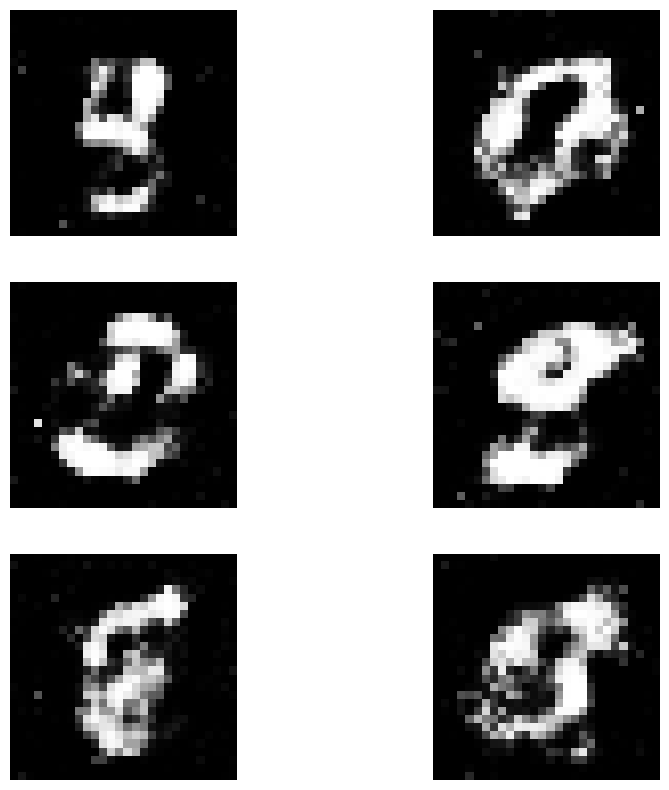

In [19]:
train(train_dataset, EPOCHS)

import matplotlib.pyplot as plt

noises = tf.random.normal([50, 100])
generated_image = G(noises, training=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for ax in axes.flat:
  ax.axis('off')

axes[0,0].imshow(generated_image[0], cmap='gray')
axes[0,1].imshow(generated_image[1], cmap='gray')
axes[1,0].imshow(generated_image[2], cmap='gray')
axes[1,1].imshow(generated_image[3], cmap='gray')
axes[2,0].imshow(generated_image[4], cmap='gray')
axes[2,1].imshow(generated_image[5], cmap='gray')

plt.show()

In [16]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_images):

  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_images = G(noises, training=True)

    real_output = D(real_images, training=True)
    fake_output = D(fake_images, training=True)

    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)

  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)

  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))

def test_step(real_images):
  noises = tf.random.normal([BATCH_SIZE, noise_dim])

  fake_images = G(noises, training=False)

  real_output = D(real_images, training=False)
  fake_output = D(fake_images, training=False)

  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)

  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

  # 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i, image_batch in enumerate(dataset):
      train_step(image_batch)
      if i == 0:
        test_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
